# Portfolio Optimization
-------------------------
## Portfolio Risk-Return optimization based on the Markowitz's Efficient Frontier and CVaR 
-------------------------

In [1]:
'''
documentation: https://pyportfolioopt.readthedocs.io/en/stable/

'''
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

%matplotlib inline

In [2]:
# Read in price (Adj Close) data from csv file (Adj Close prices pulled from the yahoo_historical.ipynb)
stock_prices = pd.read_csv("../Resources/multi_stock_prices.csv", parse_dates=True, index_col="Date")
stock_prices.tail()

,AGG,ARKK,BRK-B,ETH-USD
Date,,,,
2021-07-16,115.900002,116.529999,277.899994,1880.382935
2021-07-17,115.900002,116.529999,277.899994,1898.825195
2021-07-18,115.900002,116.529999,277.899994,1895.552124
2021-07-19,116.510002,117.279999,272.660004,1817.296631
2021-07-20,116.510002,117.279999,272.660004,1787.510742


In [3]:
from pypfopt.risk_models import CovarianceShrinkage

# Calculate expected returns (CAPM based) and covariance (Ledoid Wolf covariance shrinkage)
mu = expected_returns.capm_return(stock_prices)
S = CovarianceShrinkage(stock_prices).ledoit_wolf()

# Print expected returns
mu

AGG        0.027398
ARKK       0.187875
BRK-B      0.113598
ETH-USD    1.490783
Name: mkt, dtype: float64

In [4]:
# Specify allocation constraints for each sector or individual security

sector_mapper = {
            "ETH-USD": "crypto",
            "AGG": "bonds",
            "BRK-B": "value",
            "ARKK": "growth"
        }

sector_lower = {
            "value": 0.40, # min 50% equity
            "bonds": 0.10, # min 10% bonds
            "growth": 0.40, # min 40% growth
            "crypto": 0.02 # min 1% crypto
            } 

sector_upper = {
            "crypto": 0.02, # less than 2% crypto
            "value": 0.70, # less than 70% value
            "growth": 0.40, # less than 60% growth
            "bonds": 0.11 # less than 15% bonds
            }

In [5]:
# Construct Efficient Frontier optimization model based on the maximum Sharpe ratio (alternatively we can optimize by minimum volatility which is a good option too - by entering w=ef.min_volatility()) and specify gamma to minimize zero weights (higher gamma means less zero weights) and sector allocation constraints

from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
w = ef.max_sharpe()
weights = ef.clean_weights()
print(ef.clean_weights())

OrderedDict([('AGG', 0.11), ('ARKK', 0.4), ('BRK-B', 0.47), ('ETH-USD', 0.02)])


/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


<AxesSubplot:title={'center':'Asset Allocation'}, xlabel='Assets', ylabel='%'>

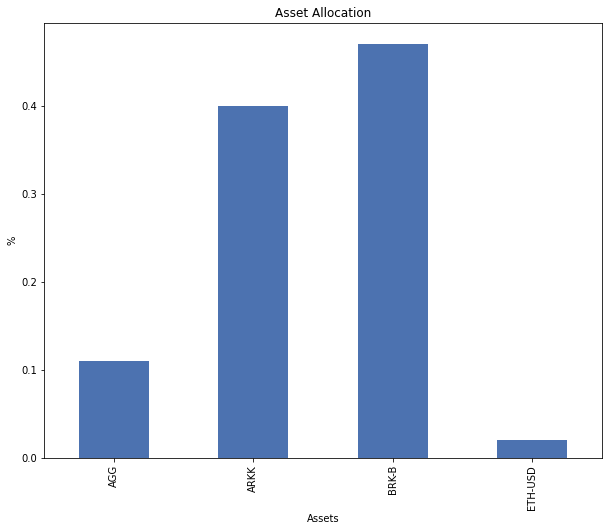

In [6]:
# Plot asset allocation based on Efficient Frontier model
pd.Series(weights).plot.bar(figsize=(10, 8), ylabel='%', xlabel ='Assets',title='Asset Allocation')

In [7]:
# Evaluate portfolio performance
ef.portfolio_performance(verbose=True)

Expected annual return: 16.1%
Annual volatility: 16.9%
Sharpe Ratio: 0.84


(0.16137078850033232, 0.16898248219494516, 0.8366002597668151)

In [8]:
# Plot Efficient Frontier based on random portfolios and  individual assets
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("../Resources/ef_scatter.png", dpi=200)
plt.show()

## Portfolio Optimization with CVaR
-------------------------------------
### Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has

In [ ]:
from pypfopt import EfficientCVaR

# Calculate expected returns (mu) and covariance (risk)
mu = expected_returns.capm_return(stock_prices)
S = CovarianceShrinkage(stock_prices).ledoit_wolf()

In [ ]:
# Portfolio optimization based on Efficient Frontier and maximum Sharpe ratio
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.max_sharpe()
weights_arr = ef.weights
ef.portfolio_performance(verbose=True)
print(f"weights = {weights_arr}")

Expected annual return: 16.7%
Annual volatility: 16.9%
Sharpe Ratio: 0.87
weights = [0.11 0.4  0.47 0.02]
/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


In [ ]:
# Calculate stock returns from historical stock prices
returns = expected_returns.returns_from_prices(stock_prices).dropna()
returns

,AGG,ARKK,BRK-B,ETH-USD
Date,,,,
2015-08-08,0.000000,0.000000,0.000000,-0.728250
2015-08-09,0.000000,0.000000,0.000000,-0.068268
2015-08-10,-0.001282,0.024210,-0.000906,0.009333
2015-08-11,0.003301,-0.013252,-0.004323,0.507323
2015-08-12,-0.000639,-0.009430,-0.008403,0.140075
...,...,...,...,...
2021-07-03,0.000000,0.000000,0.000000,0.035383
2021-07-04,0.000000,0.000000,0.000000,0.042949
2021-07-05,0.000000,0.000000,0.000000,-0.053039


<AxesSubplot:>

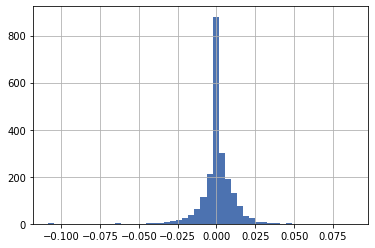

In [ ]:
# Calculate portfolio returns and plot probability distribution (normal distribution)
portfolio_rets = pd.DataFrame(returns * weights_arr).sum(axis=1)
portfolio_rets.hist(bins=50)

In [ ]:
# Calculate 95% CVaR for the max-sharpe portfolio
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

print(f"The average loss on the worst 5% of days will be {cvar :.4f}")

VaR: -1.44%
CVaR: -2.59%
The average loss on the worst 5% of days will be -0.0259


In [ ]:
# Construct a portfolio with the minimum CVar, print performance and weights

ec = EfficientCVaR(mu, returns)
ec.add_objective(objective_functions.L2_reg, gamma=0.1)
ec.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ec.min_cvar()
ec.portfolio_performance(verbose=True)
ec.weights

# We have lowered CVaR by 0.40% (from 2.65% to 2.25%) at the expense of 1.60% return (from 12.2% to 10.6%)

Expected annual return: 16.7%
Conditional Value at Risk: 2.60%


array([0.10999987, 0.4000002 , 0.46999588, 0.02000406])

In [ ]:
# Another option is to maximize return for the given CvaR (set a % CvaR that is acceptable, however make sure you understand what CvaR means). Print performance and weights

ec = EfficientCVaR(mu, returns)
ec.add_objective(objective_functions.L2_reg, gamma=0.1) # solver 'OSQP failing with this constraint (purpose to minimize zero weights)
ec.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ec.efficient_risk(target_cvar=0.05)
ec.portfolio_performance(verbose=True)
ec.weights.round(2)

Expected annual return: 16.8%
Conditional Value at Risk: 2.99%


array([0.1 , 0.4 , 0.48, 0.02])

In [ ]:
# Original portfolio performance and weights based on max Sharpe ratio
ef.portfolio_performance(verbose=True)
ef.weights.round(2)

Expected annual return: 16.7%
Annual volatility: 16.9%
Sharpe Ratio: 0.87


array([0.11, 0.4 , 0.47, 0.02])